In [1]:
require(data.table)
require(cowplot)
require(ggplot2)
require(pbapply)

Loading required package: data.table

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: ggplot2

Loading required package: pbapply



# Using datasets with intensity threshold set per field of view
And using only *matched* dots, i.e.,:

- `60x_dw` and `60x_raw` dots were matched to one another to set a reference dot set, which is the reported one.
- `20x_dw` and `20x_raw` dots were matched to the reference dot set. Only matched dots are used in this analysis.

In [2]:
dots_data = rbindlist(list(
    fread("../../data/60x_reference/ref__dw.field_thr.tsv"),
    fread("../../data/60x_reference/ref_raw.field_thr.tsv"),
    fread("../../data/magnifications_matching/20x_dw.field_thr.selected.tsv"),
    fread("../../data/magnifications_matching/20x_raw.field_thr.selected.tsv")
))

> Discarding fields #6 and #7

In [3]:
ddata = dots_data[sid <= 5]

In [4]:
pdata = ddata[, .N, by=c("magnification", "image_type", "sid", "nid", "size")]

## Statistics of DPN per dataset

In [5]:
print(pdata[, as.list(summary(N)), by=c("magnification", "image_type")])

   magnification image_type Min. 1st Qu. Median     Mean 3rd Qu. Max.
1:           60x         dw    1       2      7 13.64608      18  116
2:           60x        raw    1       2      7 13.66890      18  116
3:           20x         dw    1       2      6 11.05604      15   81
4:           20x        raw    1       2      6 10.80633      14   79


## Statistics of DPN per dataset

In [6]:
l = lapply(split(pdata, list(pdata$magnification, pdata$image_type)),
      function(ppdata) {
          out = ppdata[, as.list(summary(N)), by=c("magnification", "image_type", "sid")]
          print(ppdata[1, paste0(magnification, ".", image_type)])
          print(out)
          return(out)
      }
)

[1] "20x.dw"
   magnification image_type sid Min. 1st Qu. Median      Mean 3rd Qu. Max.
1:           20x         dw   1    1       2      5  9.742857   14.00   58
2:           20x         dw   2    1       2      6 11.132812   15.25   78
3:           20x         dw   3    1       1      3  8.600000   11.00   81
4:           20x         dw   4    1       2      6 11.288288   13.50   58
5:           20x         dw   5    1       3      7 13.416058   18.00   64
[1] "60x.dw"
   magnification image_type sid Min. 1st Qu. Median     Mean 3rd Qu. Max.
1:           60x         dw   1    1    2.00      6 11.45946   15.00   78
2:           60x         dw   2    1    3.00      9 14.92000   20.00  116
3:           60x         dw   3    1    2.00      4 10.53061   12.75  111
4:           60x         dw   4    1    2.00      7 13.11111   16.00   71
5:           60x         dw   5    1    2.75      9 16.69595   22.00   85
[1] "20x.raw"
   magnification image_type sid Min. 1st Qu. Median      Mean 3rd 

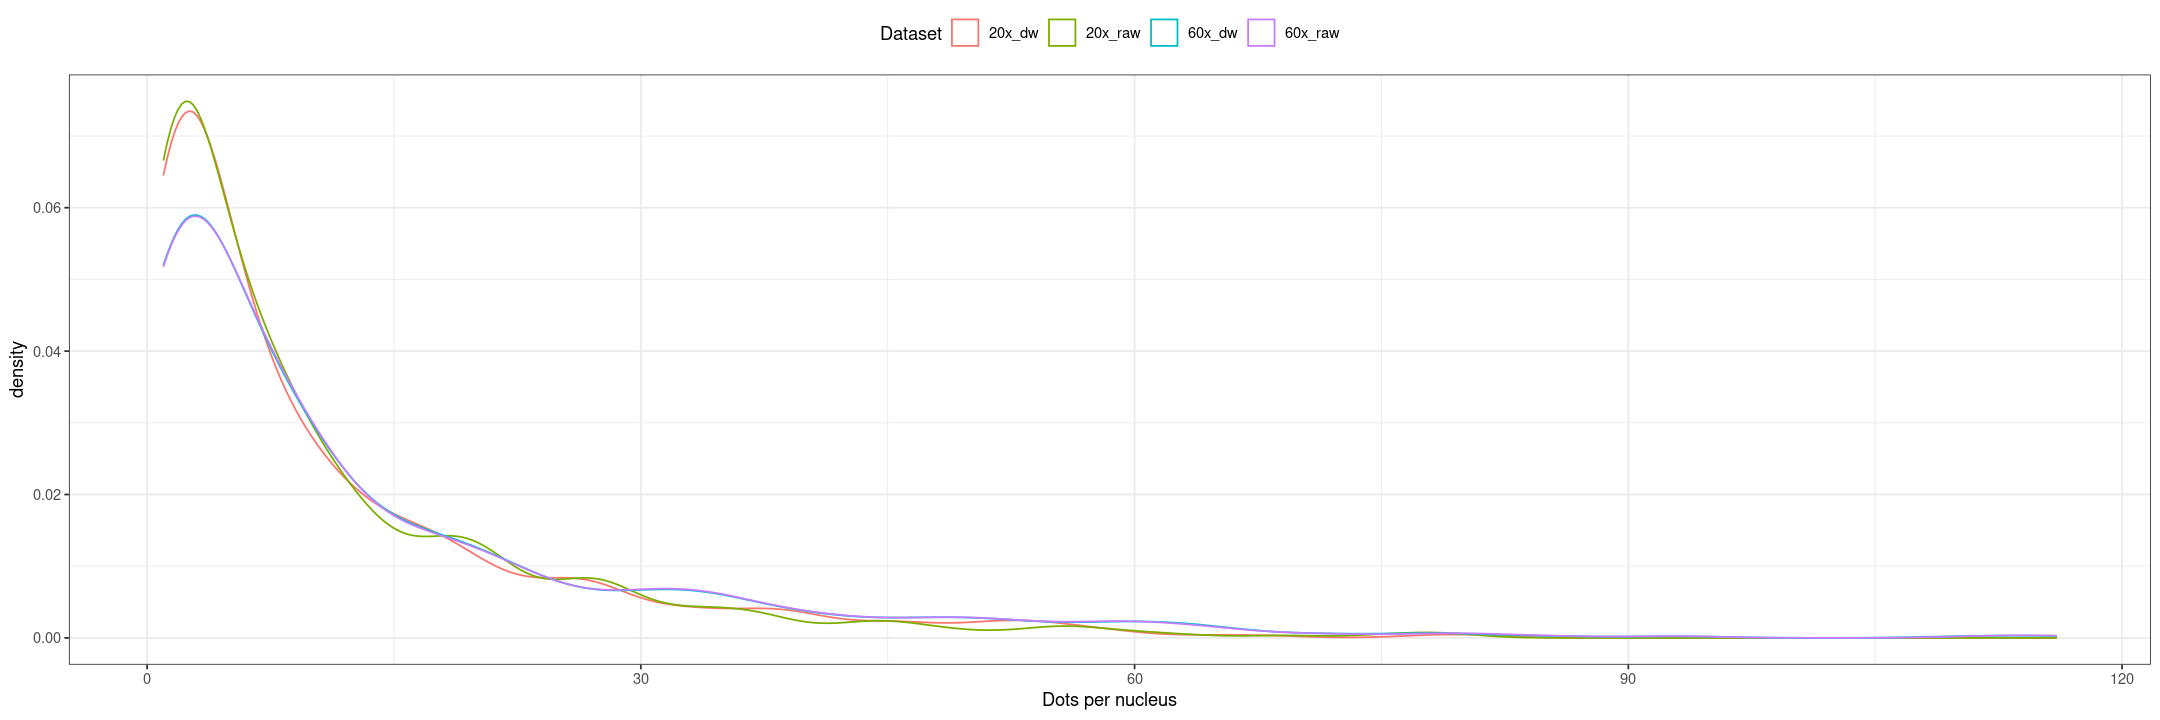

In [7]:
options(repr.plot.width=18, repr.plot.height=6)
ggplot(pdata, aes(x=N, color=paste0(magnification, "_", image_type))) + geom_density() +
    theme_bw() + theme(legend.position="top") + guides(color=guide_legend("Dataset")) +
    labs(x="Dots per nucleus")

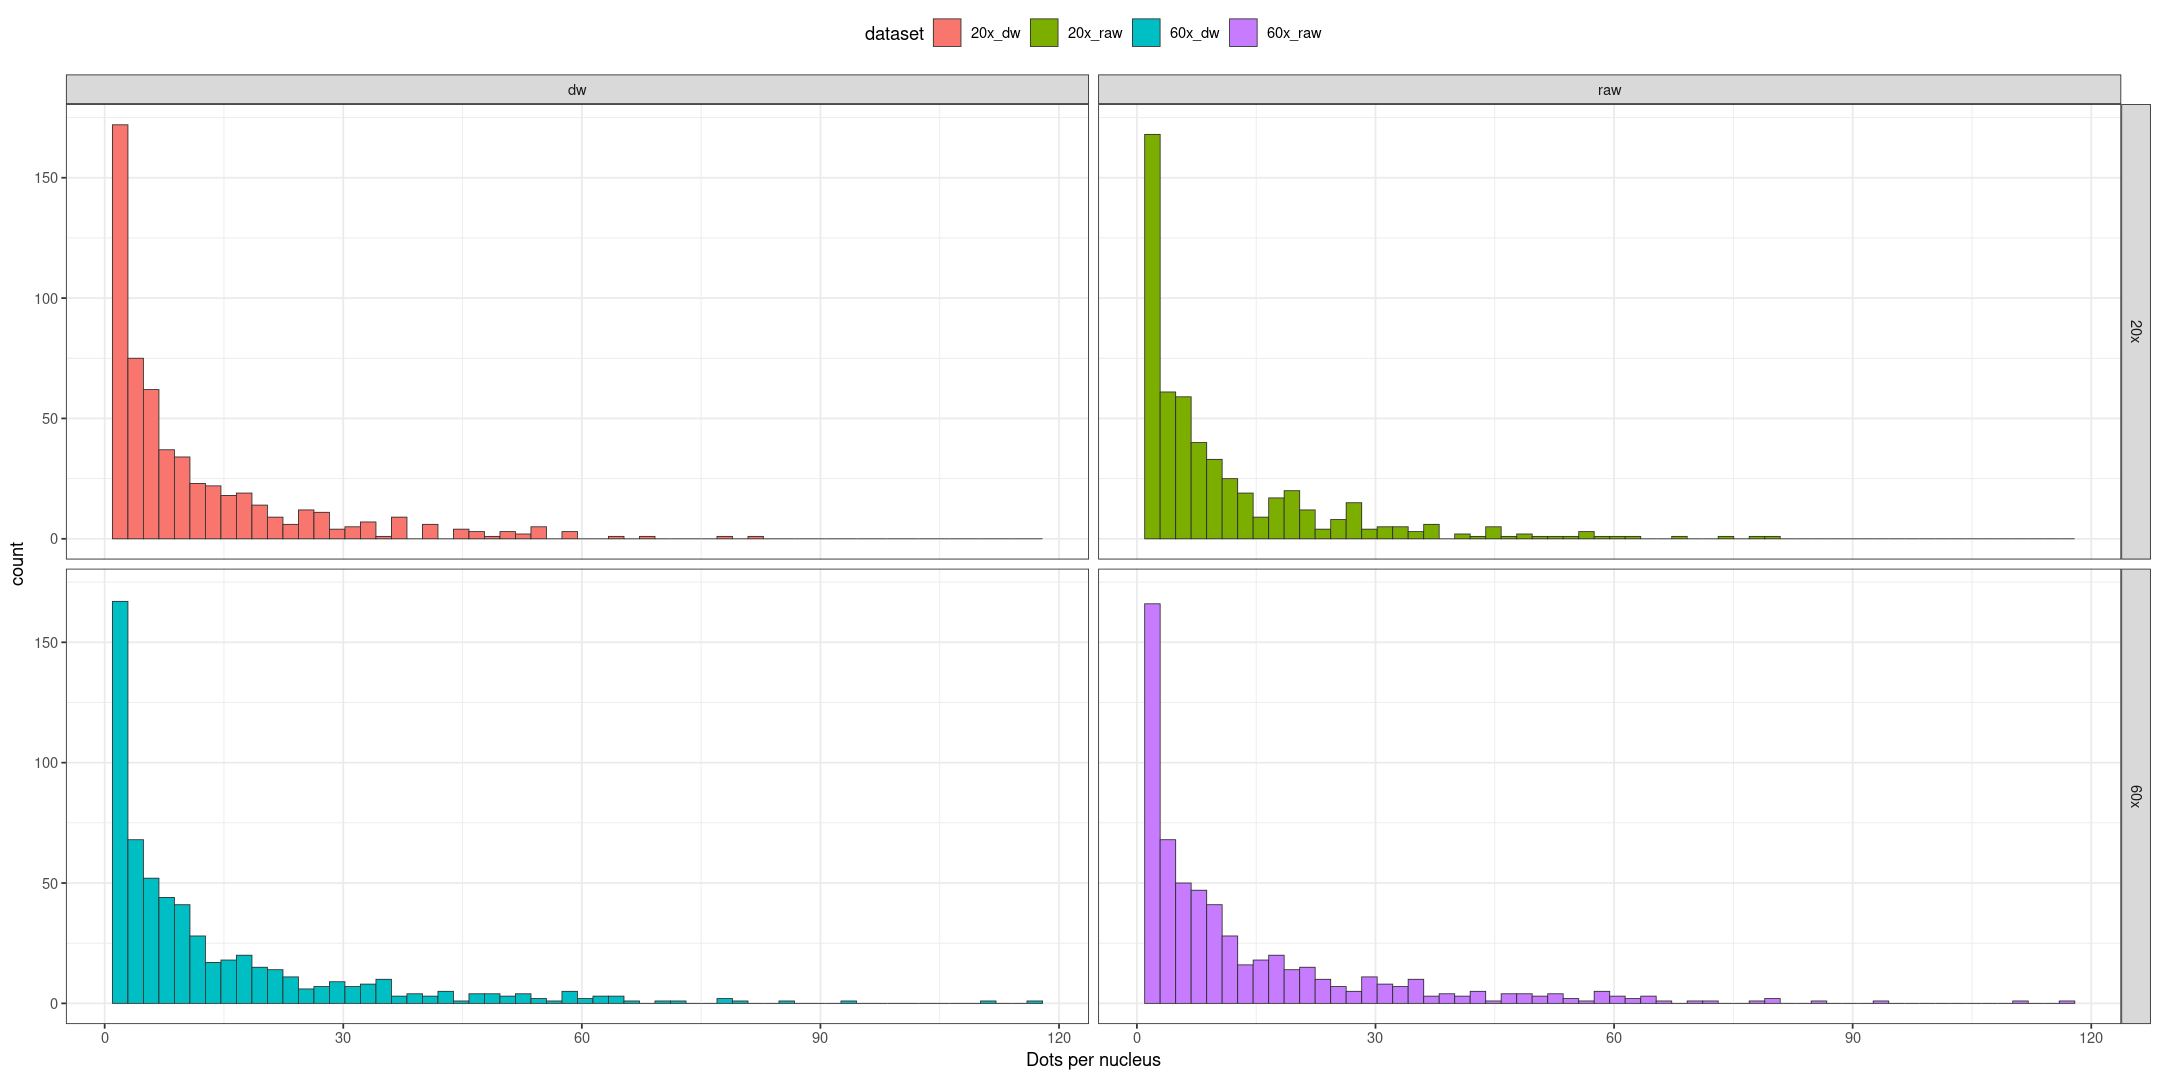

In [8]:
options(repr.plot.width=18, repr.plot.height=9)
ggplot(pdata, aes(x=N, fill=paste0(magnification, "_", image_type))) +
    geom_histogram(bins=60, color="#323232", size=.25) +
    theme_bw() + theme(legend.position="top") + guides(fill=guide_legend("dataset")) +
    labs(x="Dots per nucleus") + facet_grid(~magnification~image_type)

In [9]:
ppdata = rbindlist(pblapply(split(pdata, list(pdata$magnification, pdata$image_type)), function(ppdata) {
    p = ggplot(ppdata, aes(x=N)) + geom_histogram(bins=60)
    as.data.table(ggplot_build(p)$data[[1]])[, .(x=x, y=cumsum(y)/sum(y), magnification=ppdata[1, magnification], image_type=ppdata[1, image_type])]
}))

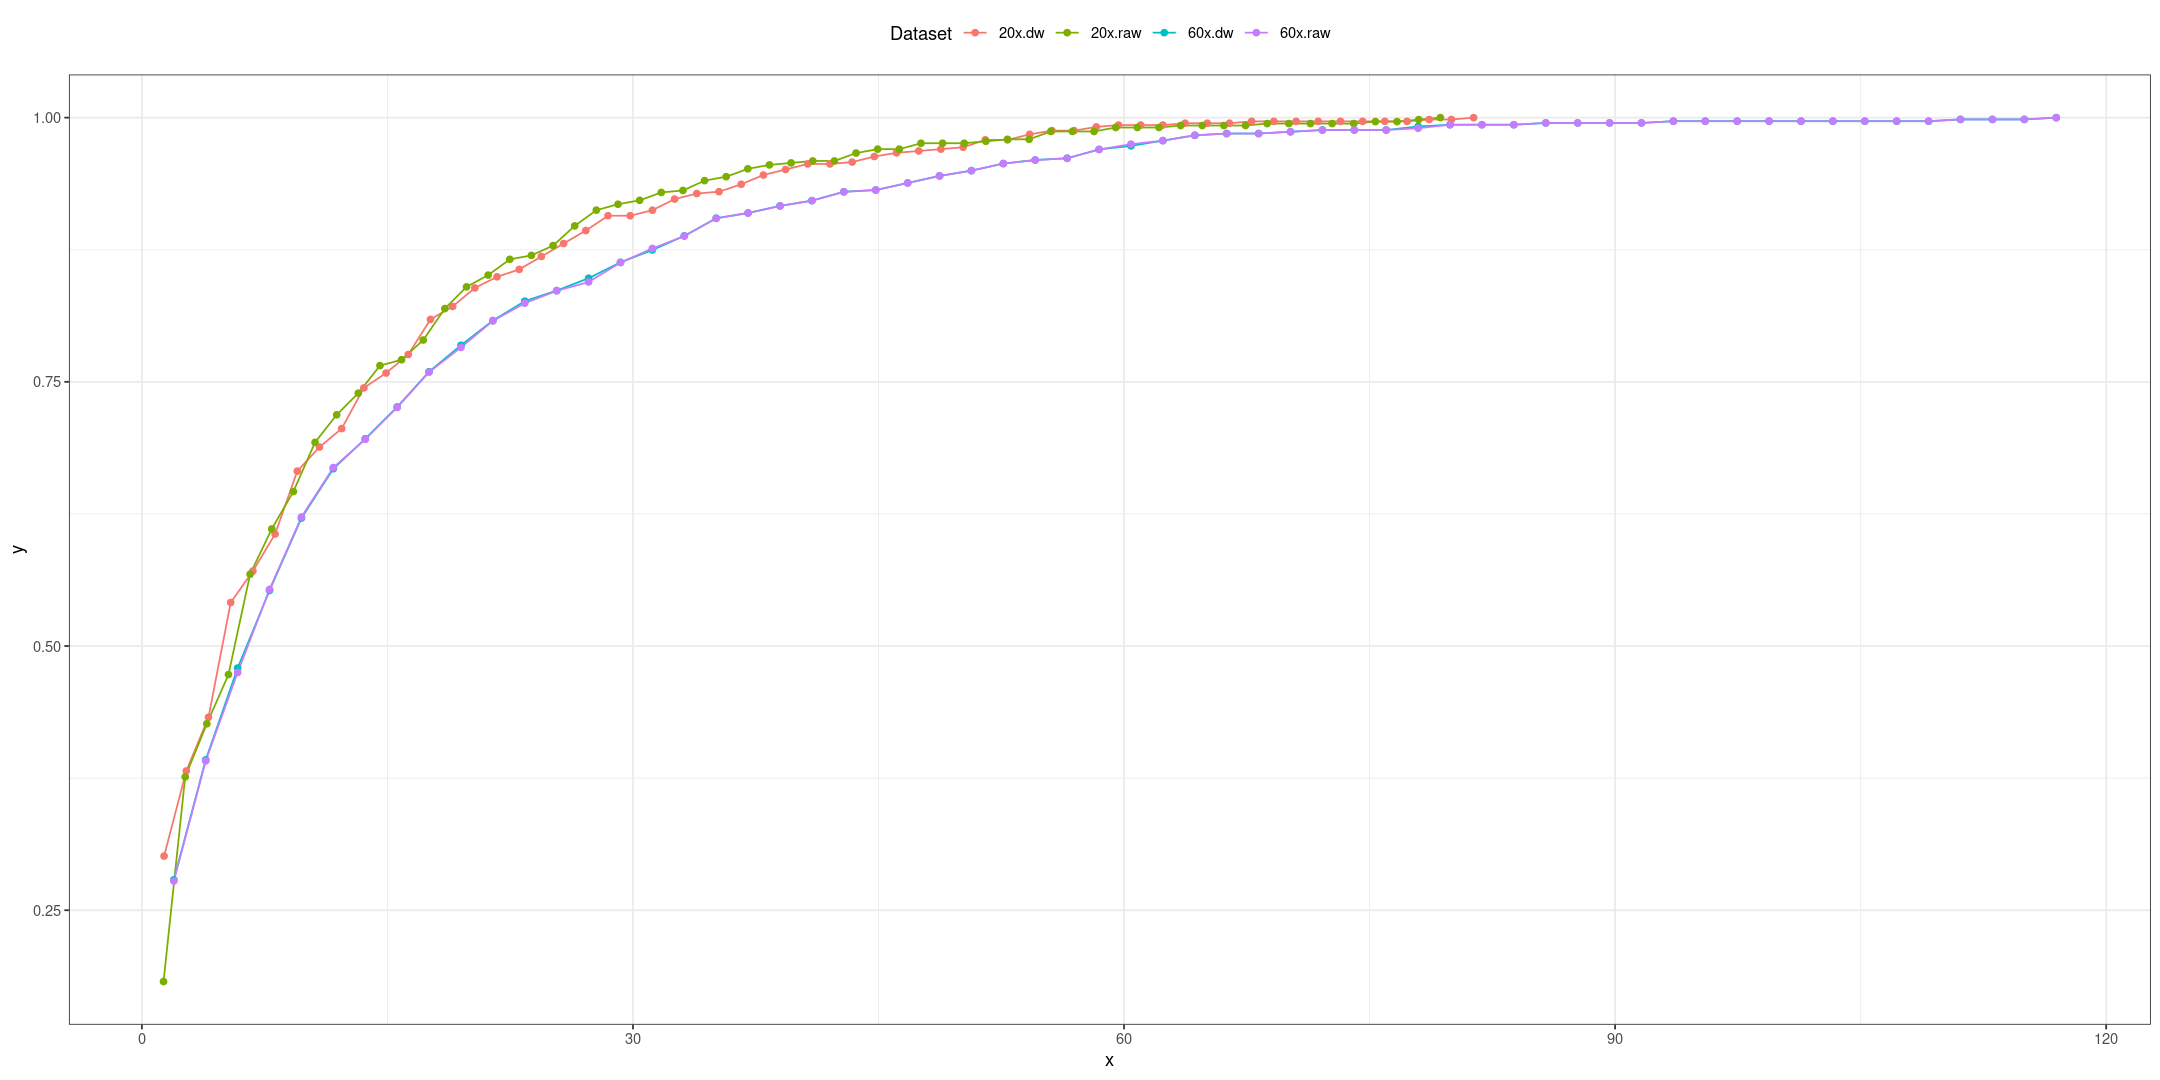

In [10]:
ggplot(ppdata, aes(x=x, y=y, color=paste0(magnification, ".", image_type))) + geom_line() + geom_point() +
    theme_bw() + labs(color="Dataset") + theme(legend.position="top")

## DPN and nuclear size

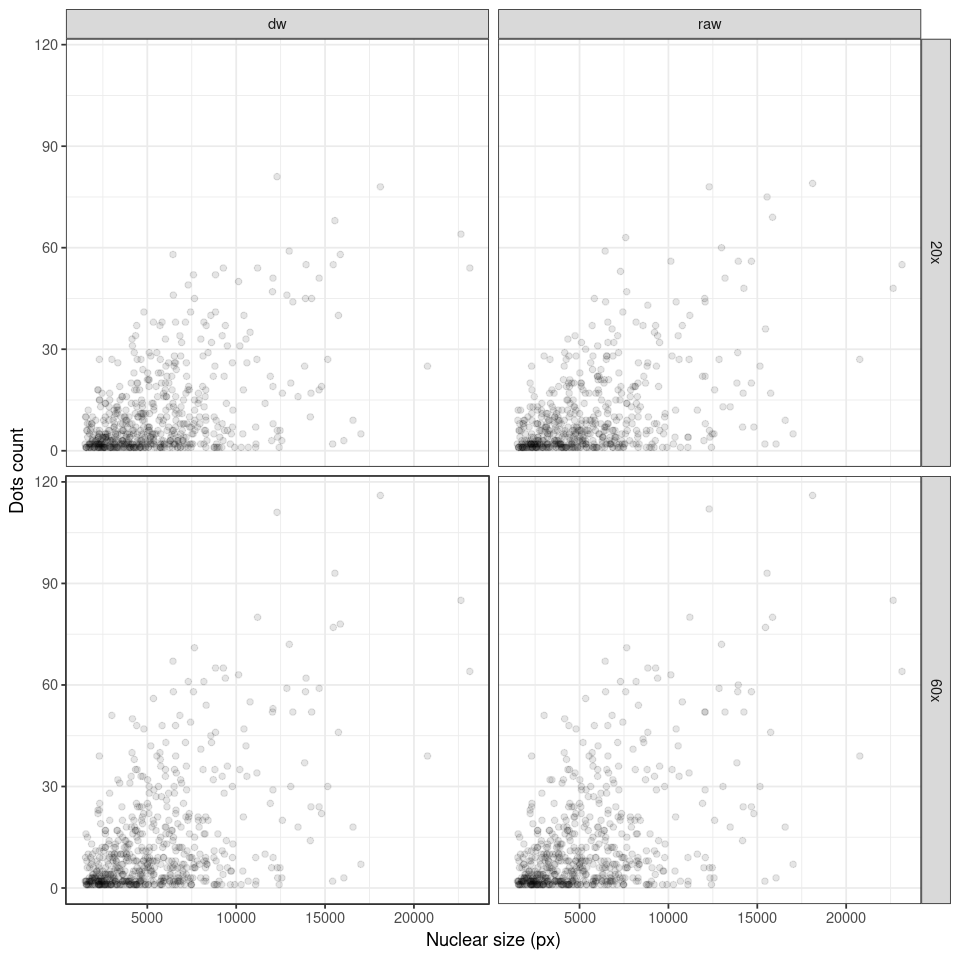

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(pdata, aes(size, N)) + geom_point(alpha=.1) +
    facet_grid(~magnification~image_type) + theme_bw() +
labs(x="Nuclear size (px)", y="Dots count")

In [12]:
ppdata = dcast(pdata, sid+nid+size~magnification+image_type, value.var="N")

In [13]:
p1 = ggplot(ppdata, aes(`60x_dw`, `60x_raw`, color=size)) + geom_point() +
    theme_bw() + coord_fixed(xlim=c(0, 120), ylim=c(0, 120)) +
    labs(title="Comparison of dots per nuclei count.")
p2 = ggplot(ppdata, aes(`60x_dw`, `20x_raw`, color=size)) + geom_point() +
    theme_bw() + coord_fixed(xlim=c(0, 120), ylim=c(0, 120)) +
    labs(title="Comparison of dots per nuclei count.")
p3 = ggplot(ppdata, aes(`60x_dw`, `20x_dw`, color=size)) + geom_point() +
    theme_bw() + coord_fixed(xlim=c(0, 120), ylim=c(0, 120)) +
    labs(title="Comparison of dots per nuclei count.")

Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 96 rows containing missing values (geom_point).”
Warning message:
“Removed 64 rows containing missing values (geom_point).”


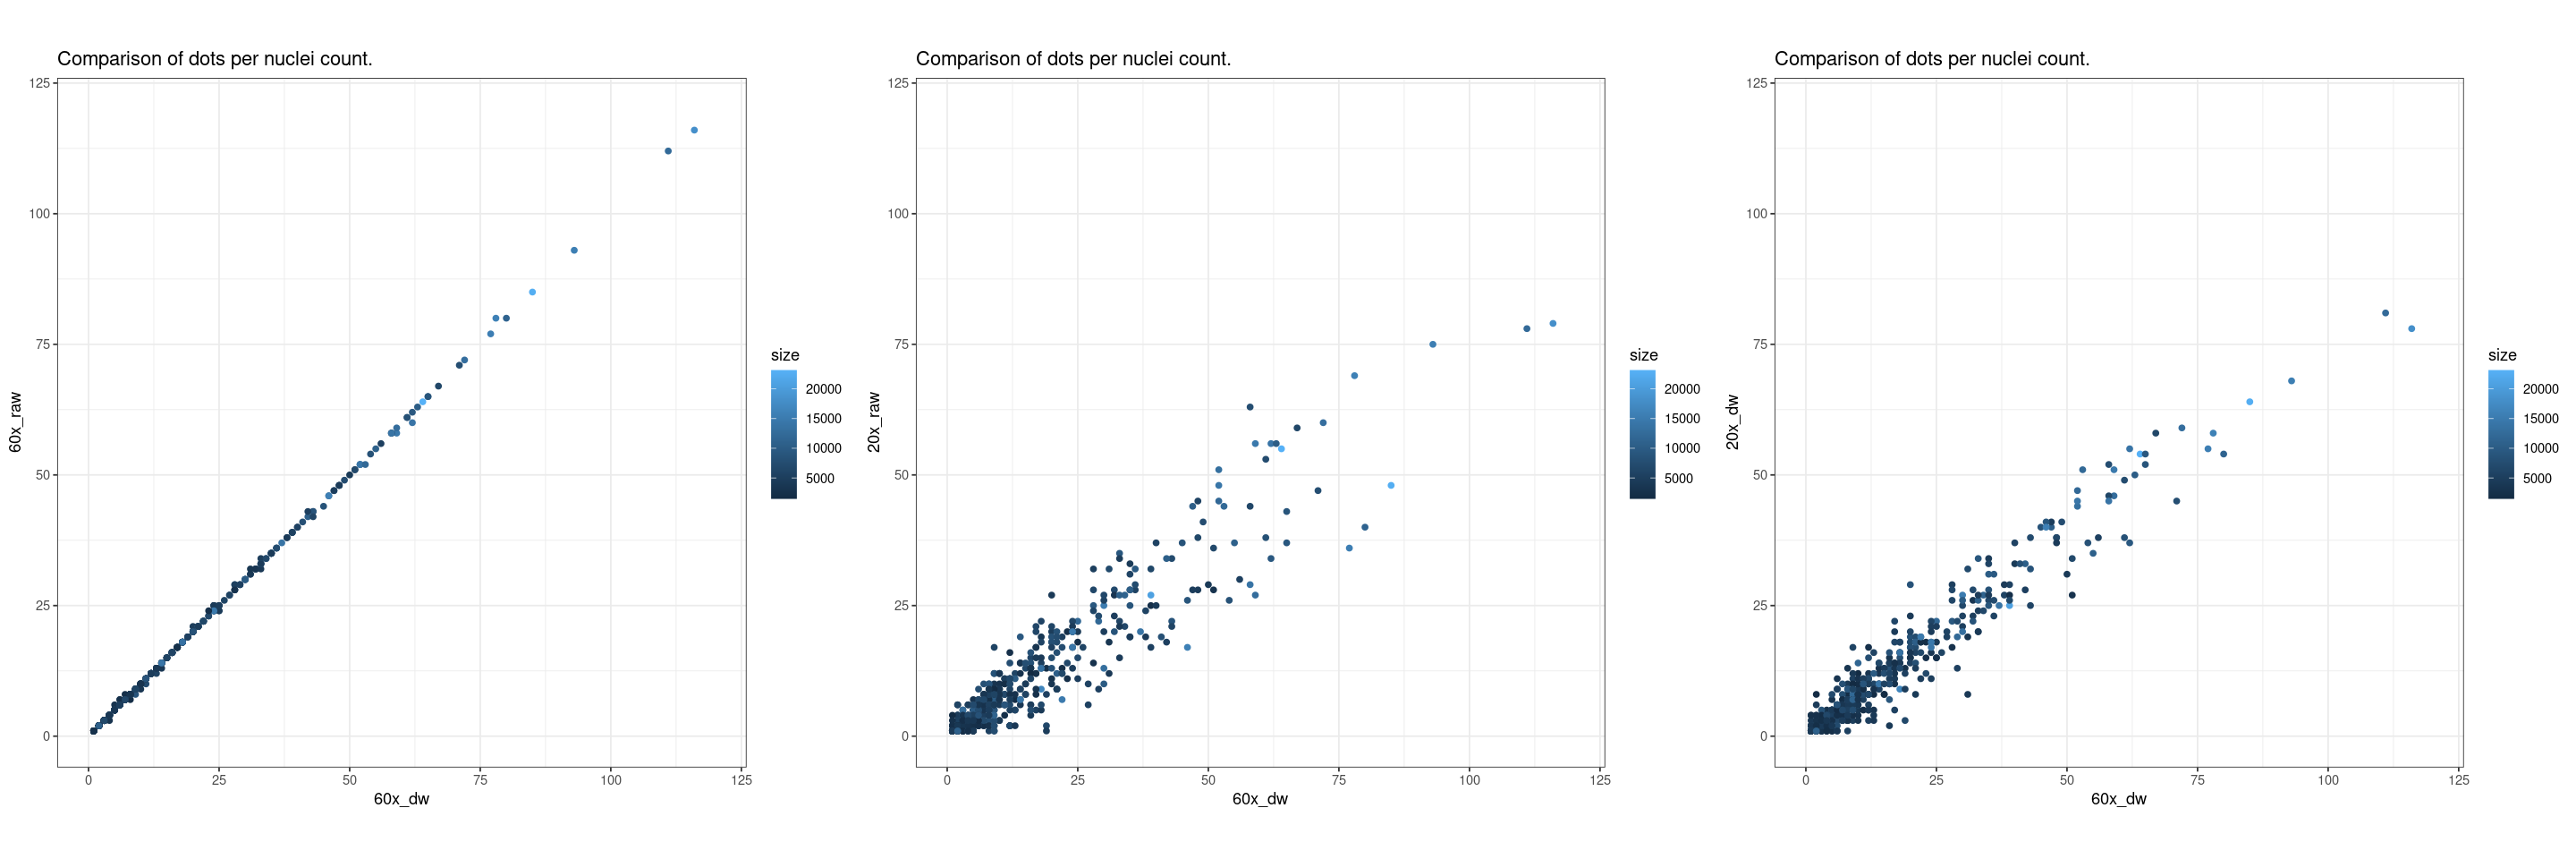

In [14]:
options(repr.plot.width=24, repr.plot.height=8)
plot_grid(p1, p2, p3, nrow=1)

In [15]:
pcc = cor(ppdata[, 4:ncol(ppdata)], use="pairwise.complete.obs")
print(pcc)
scc = cor(ppdata[, 4:ncol(ppdata)], use="pairwise.complete.obs", method="spearman")
print(scc)

           20x_dw   20x_raw    60x_dw   60x_raw
20x_dw  1.0000000 0.9620207 0.9731909 0.9728281
20x_raw 0.9620207 1.0000000 0.9388771 0.9388059
60x_dw  0.9731909 0.9388771 1.0000000 0.9998939
60x_raw 0.9728281 0.9388059 0.9998939 1.0000000
           20x_dw   20x_raw    60x_dw   60x_raw
20x_dw  1.0000000 0.9559317 0.9422229 0.9425198
20x_raw 0.9559317 1.0000000 0.9136258 0.9133179
60x_dw  0.9422229 0.9136258 1.0000000 0.9998372
60x_raw 0.9425198 0.9133179 0.9998372 1.0000000
